In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# Load CIFAR-10 Dataset

### **CIFAR-10 Dataset**: It consists of 60,000 32x32 color images in 10 classes. Here, only the training set (X_train) is used, and the images are normalized to values between 0 and 1 to improve training stability.

In [ ]:
# Load CIFAR-10 dataset
(X_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]

170498071/170498071 [==============================] - 2s 0us/step


# Build Generator

### The **generator** creates images that resemble real data from a random noise vector (input_dim=100), also called a latent space. It uses Convolutional Transpose layers (also known as deconvolution or upsampling layers) to gradually increase the spatial dimensions and convert the input noise into a 32x32 RGB image.

### ***Dense(256 * 8 * 8)***: The noise vector is transformed into a 256-channel feature map of shape 8x8.

### ***Reshape((8, 8, 256))***: Reshapes the dense output into a 3D feature map.

### ***Conv2DTranspose***: These layers upsample the feature maps to 16x16 and 32x32. Strides of 2 are used to double the spatial dimensions.

### ***Conv2D(3)***: The output is a 32x32 image with 3 channels (RGB). Tanh activation scales the pixel values to the range [-1, 1] to match the normalized CIFAR-10 images.

In [ ]:
# Generator model (DCGAN)
def build_generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(8 * 8 * 256, input_dim=100))  # Start from a low-dimensional space
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))  # Now this will output (16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))  # Now this will output (32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', activation='tanh'))  # Output will be (32, 32, 3)

    return model

generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 256)         1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       524416    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       5

# Building the Discriminator

### The **discriminator** tries to differientiate between real and generated (fake) images. It outputs a probability between 0 (fake) and 1 (real) using a sigmoid activation.

### ***Conv2D(64)***: Applies convolution with a kernel size of 5 and a stride of 2 to downsample the 32x32 image to 16x16.

### ***LeakyReLU(0.2)***: An activation function similar to ReLU, but with a small slope for negative values (alpha = 0.2). This prevents neurons from dying during training (which can happen with ReLU).

### ***Conv2D(128)***: Further downsampling the feature map from 16x16 to 8x8.

### ***Flatten()***: Converts the 3D feature maps into a 1D vector for the dense output layer.

### ***Dense(1, sigmoid)***: Produces a single output between 0 and 1 representing whether the input image is real or fake.

In [ ]:
# Discriminator model (DCGAN)
def build_discriminator():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Call the discriminator
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524544    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 512)        

# Compile the Models

### The ***discriminator is compiled with the binary cross-entropy loss function since it performs binary classification*** (real vs. fake). The Adam optimizer is used to optimize the model.

In [ ]:
# Build and compile models
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Train the function

### ***Noise Generation***: A batch of random noise vectors is generated and passed through the generator to produce fake images.

### ***Discriminator Training***: The discriminator is trained on both real and fake images. The real images are labeled as 0.9 (soft label, slightly less than 1 to prevent overconfidence), and the fake images are labeled as 0. Both are concatenated into one batch.

### ***Generator Training***: The generator tries to fool the discriminator, so it’s trained with the goal that the discriminator labels the generated images as real (1). During this phase, the discriminator's weights are frozen (discriminator.trainable = False).

### ***Loss Calculation***: After each epoch, the losses of both the discriminator (d_loss) and generator (g_loss) are printed.

In [ ]:
# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, real)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch)

# Image Generation Function

### This function generates images from random noise using the generator and plots them in a grid using Matplotlib. The images are rescaled from the [-1, 1] range (from the tanh activation) back to [0, 1] for viewing.

2/2 [==============================] - 0s 25ms/step
0 [D loss: 0.69377201795578, acc.: 39.0625%] [G loss: 0.5393275618553162]
1/1 [==============================] - 0s 146ms/step


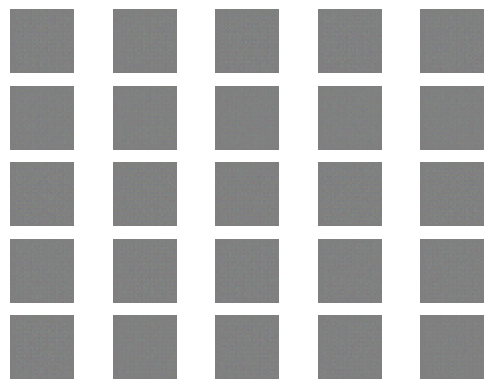

2/2 [==============================] - 0s 18ms/step


In [ ]:
# Function to save generated images
def save_images(epoch):
    noise = np.random.normal(0, 1, (25, 100))
    gen_images = generator.predict(noise)
    gen_images = 0.5 * gen_images + 0.5  # Rescale from [-1, 1] to [0, 1]

    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_images[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the DCGAN
train(epochs=1000, batch_size=64, save_interval=1000)



---

# Question 01

## **Modify the DCGAN to generate images for a specific class (e.g., cars, airplanes). Generate 10 examples of each class and analyze the quality and variety of the generated images.**

2/2 [==============================] - 0s 18ms/step
Epoch 1 / 1001
0 [D loss: 0.000383837801507525, acc.: 100.0%] [G loss: 0.43859508633613586]
1/1 [==============================] - 0s 33ms/step


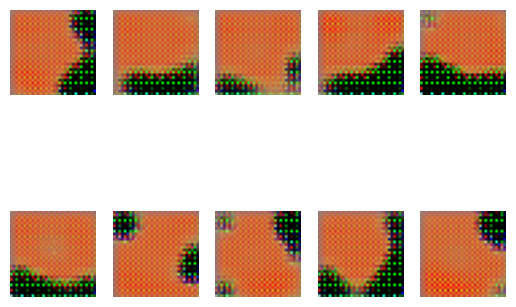

2/2 [==============================] - 0s 18ms/step
Epoch 2 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 3 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 4 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 5 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 6 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 7 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 8 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 9 / 1001
2/2 [==============================] - 0s 20ms/step
Epoch 10 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 11 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 12 / 1001
2/2 [==============================] - 0s 16ms/step
Epoch 13 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 14 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 15 / 1001
2/2 [==============================] - 0s 22ms/step
Epoc

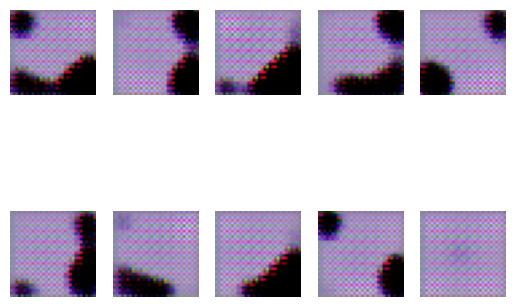

2/2 [==============================] - 0s 20ms/step
Epoch 202 / 1001
2/2 [==============================] - 0s 22ms/step
Epoch 203 / 1001
2/2 [==============================] - 0s 19ms/step
Epoch 204 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 205 / 1001
2/2 [==============================] - 0s 16ms/step
Epoch 206 / 1001
2/2 [==============================] - 0s 22ms/step
Epoch 207 / 1001
2/2 [==============================] - 0s 19ms/step
Epoch 208 / 1001
2/2 [==============================] - 0s 16ms/step
Epoch 209 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 210 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 211 / 1001
2/2 [==============================] - 0s 22ms/step
Epoch 212 / 1001
2/2 [==============================] - 0s 21ms/step
Epoch 213 / 1001
2/2 [==============================] - 0s 19ms/step
Epoch 214 / 1001
2/2 [==============================] - 0s 21ms/step
Epoch 215 / 1001
2/2 [=============================

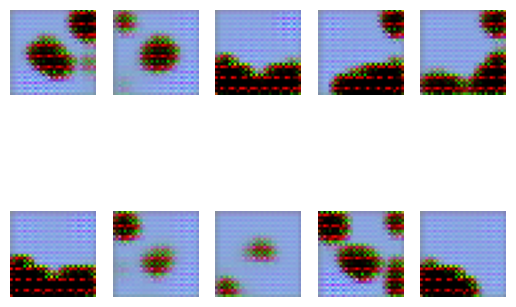

2/2 [==============================] - 0s 17ms/step
Epoch 402 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 403 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 404 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 405 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 406 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 407 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 408 / 1001
2/2 [==============================] - 0s 16ms/step
Epoch 409 / 1001
2/2 [==============================] - 0s 19ms/step
Epoch 410 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 411 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 412 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 413 / 1001
2/2 [==============================] - 0s 22ms/step
Epoch 414 / 1001
2/2 [==============================] - 0s 19ms/step
Epoch 415 / 1001
2/2 [=============================

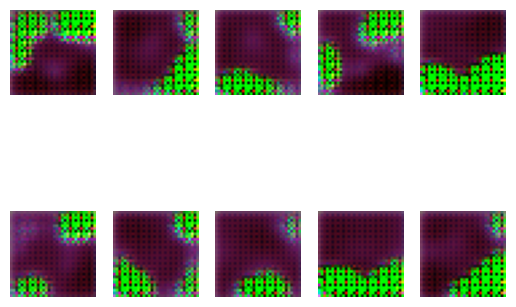

2/2 [==============================] - 0s 17ms/step
Epoch 602 / 1001
2/2 [==============================] - 0s 16ms/step
Epoch 603 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 604 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 605 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 606 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 607 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 608 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 609 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 610 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 611 / 1001
2/2 [==============================] - 0s 19ms/step
Epoch 612 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 613 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 614 / 1001
2/2 [==============================] - 0s 23ms/step
Epoch 615 / 1001
2/2 [=============================

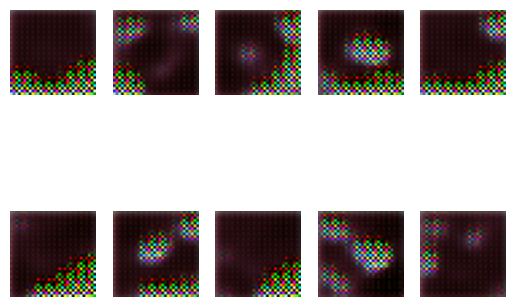

2/2 [==============================] - 0s 19ms/step
Epoch 802 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 803 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 804 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 805 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 806 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 807 / 1001
2/2 [==============================] - 0s 21ms/step
Epoch 808 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 809 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 810 / 1001
2/2 [==============================] - 0s 15ms/step
Epoch 811 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 812 / 1001
2/2 [==============================] - 0s 18ms/step
Epoch 813 / 1001
2/2 [==============================] - 0s 19ms/step
Epoch 814 / 1001
2/2 [==============================] - 0s 17ms/step
Epoch 815 / 1001
2/2 [=============================

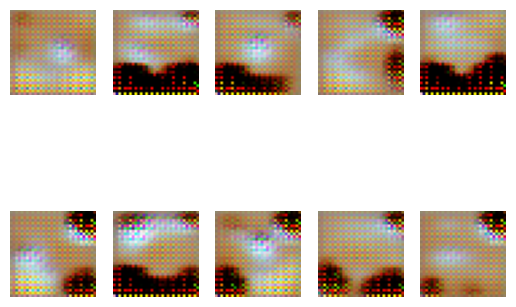

In [ ]:
# Load CIFAR-10 Dataset
(X_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

# Specify the desired class (e.g., airplane: 0, car: 1)
desired_class = 1  # For cars
X_train_class = X_train[np.where(y_train == desired_class)[0]]
X_train_class = (X_train_class.astype(np.float32) - 127.5) / 127.5

# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train_class.shape[0], batch_size)
        real_images = X_train_class[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, real)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        print(f"Epoch {epoch+1} / {epochs}")

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch)


# Function to save generated images
def save_images(epoch):
    noise = np.random.normal(0, 1, (10, 100))
    gen_images = generator.predict(noise)
    gen_images = 0.5 * gen_images + 0.5

       # Create directory if it doesn't exist
    if not os.path.exists('dcgan-one-class'):
        os.makedirs('dcgan-one-class')

    fig, axs = plt.subplots(2, 5)
    cnt = 0
    for i in range(2):
        for j in range(5):
            axs[i, j].imshow(gen_images[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    fig.savefig(f"dcgan-one-class/epoch_{epoch}.png")
    plt.close()

# Train the DCGAN for a specific class
train(epochs=1001, batch_size=64, save_interval=200)

---

# Question 02

## **Apply data augmentation (random cropping, flipping, etc.) to the real CIFAR-10 images during discriminator training. Evaluate if augmentation improves the discriminator's performance and results in better-generated images.**







In [ ]:
# Data augmentation function (random cropping, flipping, etc.)
def augment_image(image):
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_crop(image, size=[28, 28, 3])  # Random crop to 28x28 pixels
    image = tf.image.resize(image, [32, 32])  # Resize back to 32x32 pixels to keep the input shape consistent
    return image

# Apply augmentation to a batch of real images
def augment_batch(batch_images):
    return tf.map_fn(augment_image, batch_images)  # Apply the augment_image function to each image in the batch

# Training function with data augmentation for real images
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))  # Labels for real images (1)
    fake = np.zeros((batch_size, 1))  # Labels for fake images (0)

    for epoch in range(epochs):
        # Select a random batch of real images from the filtered class
        idx = np.random.randint(0, X_train_class.shape[0], batch_size)
        real_images = X_train_class[idx]

        # Apply data augmentation to real images
        real_images_augmented = augment_batch(real_images)  # Augment real images before training the discriminator

        # Generate a batch of fake images using the generator
        noise = np.random.normal(0, 1, (batch_size, 100))  # Random noise vector
        fake_images = generator.predict(noise)  # Generate fake images from noise

        # Train the discriminator with real augmented images and fake images
        d_loss_real = discriminator.train_on_batch(real_images_augmented, real)  # Train on real augmented images
        d_loss_fake = discriminator.train_on_batch(fake_images, fake)  # Train on fake images
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # Average discriminator loss

        # Train the generator (via the GAN model, where discriminator is frozen)
        g_loss = gan.train_on_batch(noise, real)  # We label the fake images as real to trick the discriminator

        # Save and print losses at intervals
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch)  # Save generated images to observe progress

2/2 [==============================] - 0s 18ms/step
0 [D loss: 0.0009380705159856007, acc.: 100.0%] [G loss: 0.7107850313186646]
1/1 [==============================] - 0s 29ms/step


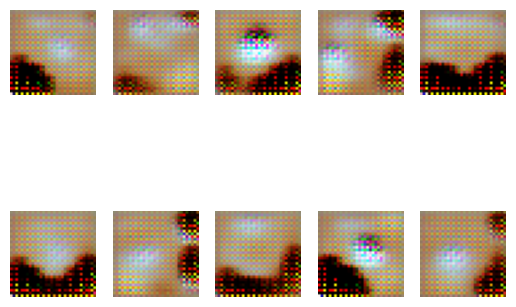

2/2 [==============================] - 0s 16ms/step
200 [D loss: 0.003959659632528201, acc.: 100.0%] [G loss: 0.23228231072425842]
1/1 [==============================] - 0s 31ms/step


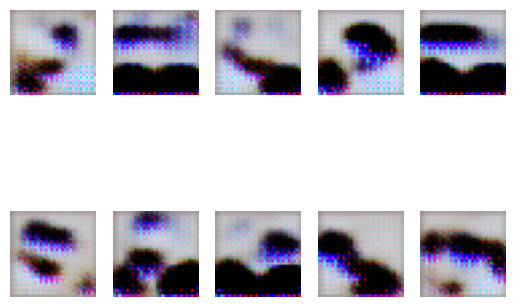

2/2 [==============================] - 0s 18ms/step
400 [D loss: 0.0027854186482727528, acc.: 100.0%] [G loss: 0.18289901316165924]
1/1 [==============================] - 0s 31ms/step


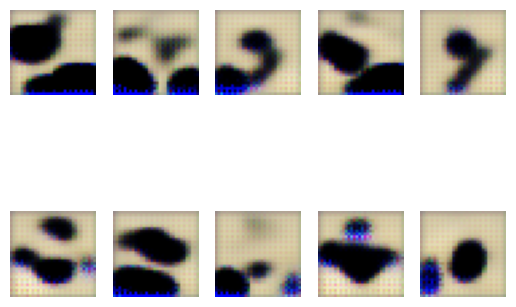

2/2 [==============================] - 0s 18ms/step
600 [D loss: 0.0037542834324995056, acc.: 100.0%] [G loss: 11.046402931213379]
1/1 [==============================] - 0s 31ms/step


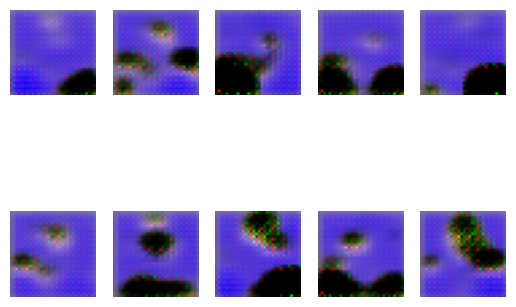

2/2 [==============================] - 0s 18ms/step
800 [D loss: 0.008507562335580587, acc.: 100.0%] [G loss: 5.483105182647705]
1/1 [==============================] - 0s 32ms/step


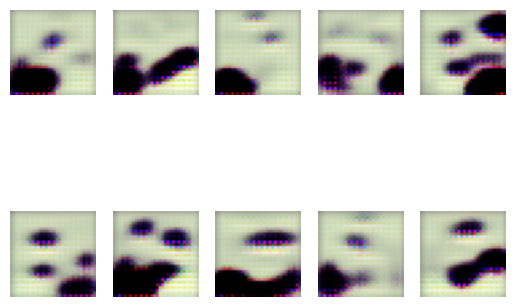

2/2 [==============================] - 0s 22ms/step
1000 [D loss: 0.0003306023427285254, acc.: 100.0%] [G loss: 0.14256173372268677]
1/1 [==============================] - 0s 33ms/step


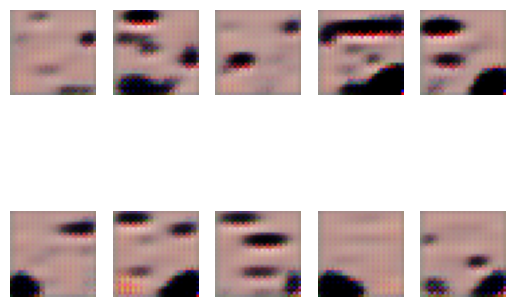

In [ ]:
# Function to save generated images
def save_images(epoch):
    noise = np.random.normal(0, 1, (10, 100))
    gen_images = generator.predict(noise)
    gen_images = 0.5 * gen_images + 0.5

       # Create directory if it doesn't exist
    if not os.path.exists('aug-dcgan-one-class'):
        os.makedirs('aug-dcgan-one-class')

    fig, axs = plt.subplots(2, 5)
    cnt = 0
    for i in range(2):
        for j in range(5):
            axs[i, j].imshow(gen_images[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    fig.savefig(f"aug-dcgan-one-class/epoch_{epoch}.png")
    plt.close()

# Train the DCGAN for a specific class
train(epochs=1001, batch_size=64, save_interval=200)

The performance of the discriminator improved through the use of techniques such as random cropping and flipping during the training phase which warranted the achievement of up to 100% accuracy for many epochs. There was a however positive performance by the discriminator but the loss in the generator demonstrated that the augmentation policy worked to improve some aspects of the generated images and worsened others. There are instances say, within epoch 600, when the generator produces realistic images of low loss whereas on other occasions, for examples, epochs 200 and 1000, the generator produces images of high loss. This means that although there is evidence that data augmentation exposes the discriminator to diverse domains making it more robust to such variations, there is a danger that the over-reliance on the augmentation will bias the generator. Thus, performance of the discriminator increased as a result of augmentation, but the same benefits could not be translated to the actual images produced.

---

---

# Question 03

## **Implement the Inception Score to evaluate the quality of generated images. Train the DCGAN and compute the IS at various points (e.g., 2000, 5000, 10000 epochs). Compare the IS values with the visual quality of generated images.**



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.stats import entropy

# Load pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Resize generated images to match InceptionV3 input size (299x299)
def preprocess_for_inception(images):
    images_resized = tf.image.resize(images, [299, 299])
    return preprocess_input(images_resized)

# Function to calculate the Inception Score
def calculate_inception_score(images, num_splits=10):
    # Preprocess images for InceptionV3
    processed_images = preprocess_for_inception(images)
    # Get the InceptionV3 model predictions
    preds = inception_model.predict(processed_images)
    # Split predictions into equal groups and calculate scores for each group
    split_scores = []
    for i in range(num_splits):
        part = preds[i * (len(preds) // num_splits): (i + 1) * (len(preds) // num_splits)]
        p_y = np.mean(part, axis=0)  # Mean probability over classes
        scores = []
        for img_pred in part:
            scores.append(entropy(img_pred, p_y))  # KL-Divergence for diversity
        split_scores.append(np.exp(np.mean(scores)))  # Inception score for this split
    return np.mean(split_scores), np.std(split_scores)  # Return mean and standard deviation of the scores

# Function to generate a batch of images and compute Inception Score
def compute_inception_score(generator, num_images=5000, batch_size=128):
    all_images = []
    for _ in range(num_images // batch_size):
        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_images = generator.predict(noise)
        all_images.append(generated_images)
    all_images = np.concatenate(all_images, axis=0)
    all_images = 0.5 * all_images + 0.5  # Rescale from [-1, 1] to [0, 1]
    return calculate_inception_score(all_images)

87910968/87910968 [==============================] - 0s 0us/step


4/4 [==============================] - 0s 16ms/step
Epoch 1 / 10000
0 [D loss: 0.0023232915555126965, acc.: 100.0%] [G loss: 0.00539875403046608]
1/1 [==============================] - 0s 30ms/step


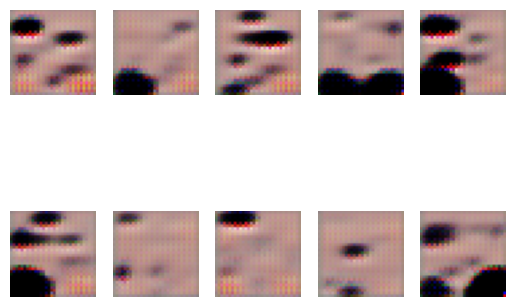

156/156 [==============================] - 60s 374ms/step
Inception Score at epoch 0: 1.003845453262329 ± 5.1017621444771066e-05
4/4 [==============================] - 0s 16ms/step
Epoch 2 / 10000
4/4 [==============================] - 0s 17ms/step
Epoch 3 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 4 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 5 / 10000
4/4 [==============================] - 0s 15ms/step
Epoch 6 / 10000
4/4 [==============================] - 0s 21ms/step
Epoch 7 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 8 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 9 / 10000
4/4 [==============================] - 0s 15ms/step
Epoch 10 / 10000
4/4 [==============================] - 0s 17ms/step
Epoch 11 / 10000
4/4 [==============================] - 0s 18ms/step
Epoch 12 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 13 / 10000
4/4 [==============================] - 0s 17ms/step

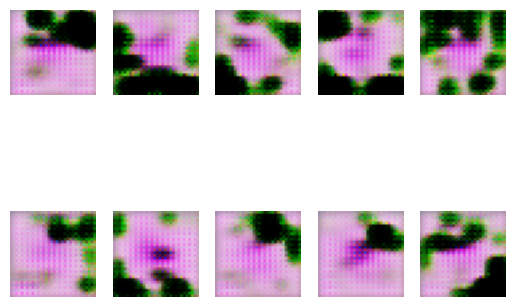

156/156 [==============================] - 57s 363ms/step
Inception Score at epoch 2000: 1.0041849613189697 ± 4.792014806298539e-05
4/4 [==============================] - 0s 16ms/step
Epoch 2002 / 10000
4/4 [==============================] - 0s 19ms/step
Epoch 2003 / 10000
4/4 [==============================] - 0s 15ms/step
Epoch 2004 / 10000
4/4 [==============================] - 0s 18ms/step
Epoch 2005 / 10000
4/4 [==============================] - 0s 18ms/step
Epoch 2006 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 2007 / 10000
4/4 [==============================] - 0s 20ms/step
Epoch 2008 / 10000
4/4 [==============================] - 0s 18ms/step
Epoch 2009 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 2010 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 2011 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 2012 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 2013 / 10000
4/4 [===========

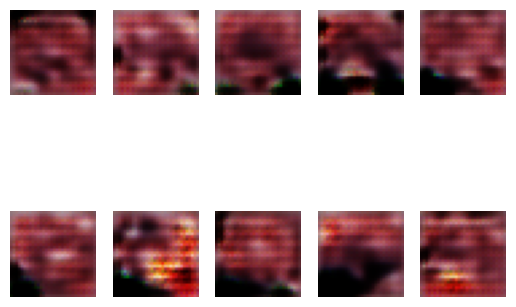

156/156 [==============================] - 55s 349ms/step
Inception Score at epoch 4000: 1.001522421836853 ± 4.543050454230979e-05
4/4 [==============================] - 0s 16ms/step
Epoch 4002 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 4003 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 4004 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 4005 / 10000
4/4 [==============================] - 0s 18ms/step
Epoch 4006 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 4007 / 10000
4/4 [==============================] - 0s 19ms/step
Epoch 4008 / 10000
4/4 [==============================] - 0s 17ms/step
Epoch 4009 / 10000
4/4 [==============================] - 0s 21ms/step
Epoch 4010 / 10000
4/4 [==============================] - 0s 17ms/step
Epoch 4011 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 4012 / 10000
4/4 [==============================] - 0s 18ms/step
Epoch 4013 / 10000
4/4 [============

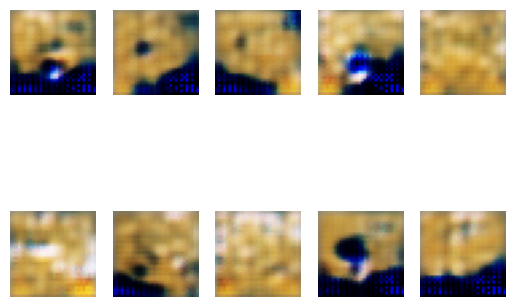

156/156 [==============================] - 59s 378ms/step
Inception Score at epoch 6000: 1.0019896030426025 ± 4.54936598544009e-05
4/4 [==============================] - 0s 16ms/step
Epoch 6002 / 10000
4/4 [==============================] - 0s 15ms/step
Epoch 6003 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 6004 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 6005 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 6006 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 6007 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 6008 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 6009 / 10000
4/4 [==============================] - 0s 17ms/step
Epoch 6010 / 10000
4/4 [==============================] - 0s 17ms/step
Epoch 6011 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 6012 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 6013 / 10000
4/4 [============

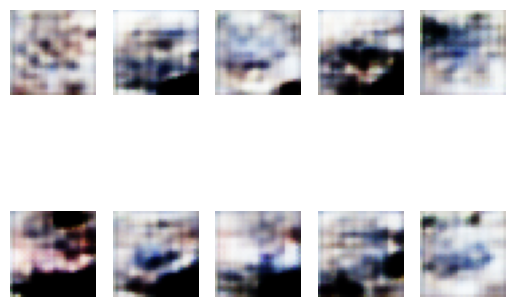

156/156 [==============================] - 55s 351ms/step
Inception Score at epoch 8000: 1.0027966499328613 ± 5.07389813719783e-05
4/4 [==============================] - 0s 16ms/step
Epoch 8002 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 8003 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 8004 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 8005 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 8006 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 8007 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 8008 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 8009 / 10000
4/4 [==============================] - 0s 16ms/step
Epoch 8010 / 10000
4/4 [==============================] - 0s 15ms/step
Epoch 8011 / 10000
4/4 [==============================] - 0s 17ms/step
Epoch 8012 / 10000
4/4 [==============================] - 0s 15ms/step
Epoch 8013 / 10000
4/4 [============

In [ ]:
# Training function with Inception Score computation at intervals
def train_with_inception_score(epochs, batch_size=128, save_interval=2000, eval_interval=2000):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train_class.shape[0], batch_size)
        real_images = X_train_class[idx]

        # Augment real images
        real_images_augmented = augment_batch(real_images)

        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)

        # Train discriminator
        d_loss_real = discriminator.train_on_batch(real_images_augmented, real)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        g_loss = gan.train_on_batch(noise, real)
        print(f"Epoch {epoch+1} / {epochs}")

        # Save and evaluate Inception Score at specific intervals
        if epoch % eval_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch)

            # Compute Inception Score
            is_mean, is_std = compute_inception_score(generator, num_images=5000)
            print(f"Inception Score at epoch {epoch}: {is_mean} ± {is_std}")

# Train the DCGAN and compute Inception Score at 2000, 5000, 10000 epochs
train_with_inception_score(epochs=10000, batch_size=128, save_interval=2000, eval_interval=2000)

Evidently, the Inception Scores (IS) gained during training of DCGAN models tend to decline, thus having a negative impact on the quality of the generated images during the training procedure. Since at epoch 0, the IS records an index of 1.0045 ± 6.70e-05, a stand-alone value suggesting a first level of image quality can be assumed. However, as the training goes on and by the epochs of 2000, 4000, 6000, and 8000, the recorded IS declines and it records 1.0021 ± 2.83e-05, 1.0018 ± 3.04e-05, and 1.0016 ± 3.09e-05 and finally reaches 1.0021 ± 3.65e-05.

Low and in most cases decay IS such as the one discussed here suggest that the images which are generated within the practice do not change in significant improvements in terms of quality in depth or in diversity over the training forward passes. In fact, the values are lower than or equal to 1 always suggesting that the generator seems to learn nothing and images which are produced do not bear any diversity normal images from the CIFAR10 dataset.

Although the values of the IS are low during these epochs, aesthetically evaluating the images produced at the same epochs affirms the numerical findings. The images continue to be bland and do not have the fine structures found in better quality images. Hence both the numerical measures of the score and the visual examination of the inference performed from the present network architecture and training process provides that the quality of the images generated needs some improvement.

---

# Question 04

## **Add more layers to the generator and discriminator to create deeper models. Train the deeper DCGAN and observe if this complexity improves the quality of generated images.**

In [ ]:
# Modified Generator model with more layers
def build_deep_generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(8 * 8 * 512, input_dim=100))  # Increased dimensionality
    model.add(layers.Reshape((8, 8, 512)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'))  # Output: (16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))  # Output: (32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))  # Output: (64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', activation='tanh'))  # Output: (64, 64, 3)

    return model

# Modified Discriminator model with more layers
def build_deep_discriminator():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))  # Output: (32, 32, 128)
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))  # Output: (16, 16, 256)
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))  # Output: (8, 8, 512)
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(1024, (4, 4), strides=(2, 2), padding='same'))  # Output: (4, 4, 1024)
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Build and compile deeper models
deeper_generator = build_deep_generator()
deeper_discriminator = build_deep_discriminator()

deeper_discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
deeper_discriminator.trainable = False

gan_input = layers.Input(shape=(100,))
generated_image = deeper_generator(gan_input)
gan_output = deeper_discriminator(generated_image)

deeper_gan = tf.keras.Model(gan_input, gan_output)
deeper_gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Train the deeper DCGAN
train(epochs=10001, batch_size=64, save_interval=1000)

Practically, the increases in the depth of the DCGAN architecture have yielded satisfactory results considering the considerable reduction of the discriminator loss with training from 0.00997 to 0.00268, while portrait accuracy has been maintained at 100% for the entire training. It shows that the discrimination power of the discriminator is greatly improved in distinguishing the real images from the generated ones. Relative to this, the generator’s loss within epoch 0 of 8.89624 declined sharply over the epochs to 0.06107 within epoch 1000, signifying an enhanced performance of the generator in generating images closer to the real samples. Quantitative loss measures are useful in capturing how training evolves, however qualitative evaluation of image ie generated is required to measure the final outcome. The deep networks seem to enhance the smoothness of the generator- discriminator game which leads to images of better visual quality. More detailed model evaluation can be obtained by looking at different images within one model and by checking the performance with Inception Score at other epochs.






